# import libraries

In [1]:
import os
from os import listdir, makedirs
from os.path import join, exists  


from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# load data 

## train data

In [2]:
train_data = ImageDataGenerator(
    rescale=1./255 , zoom_range=0.2
).flow_from_directory(
    directory='train',target_size=(224,224),class_mode='binary')

Found 978 images belonging to 2 classes.


## test data

In [3]:
test_data = ImageDataGenerator(
    rescale=1./255 , zoom_range=0.2
).flow_from_directory(
    directory='test',target_size=(224,224),class_mode='binary')

Found 240 images belonging to 2 classes.


# visualizing data distribution

In [4]:
training_dataframe = pd.DataFrame(train_data.classes, columns=['classes'])
test_dataframe = pd.DataFrame(test_data.classes, columns=['classes'])

In [5]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

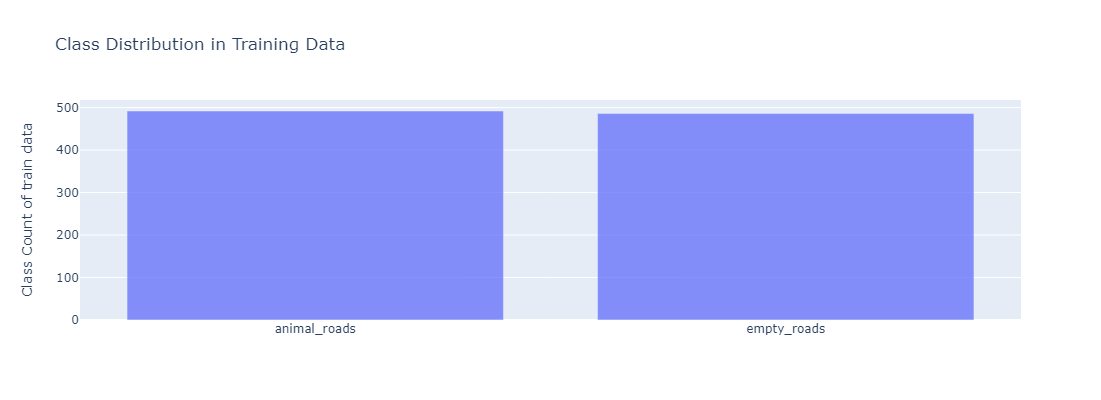

In [6]:
x1, y1 = create_stack_bar_data('classes', training_dataframe)
x1 = list(train_data.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Training Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count of train data'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

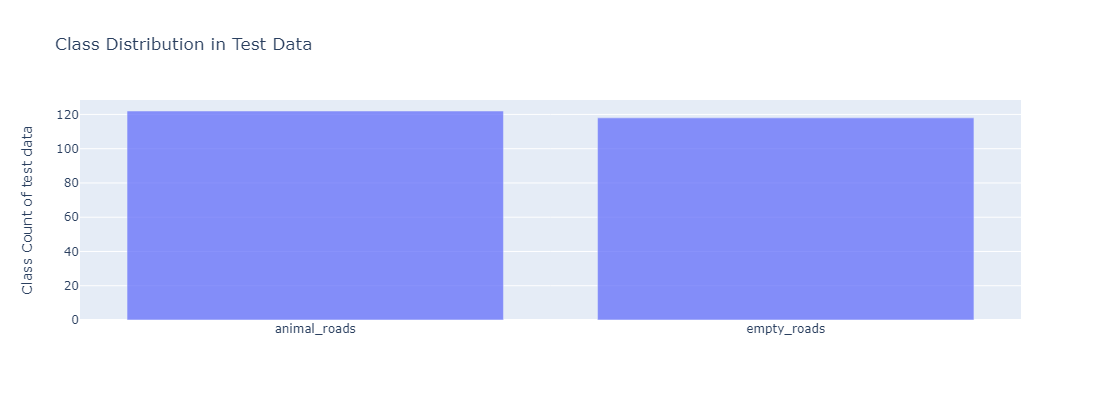

In [7]:
x1, y1 = create_stack_bar_data('classes', test_dataframe)
x1 = list(test_data.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Test Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count of test data'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

# Model 1 - VGG16

In [8]:
vgg= tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape= (224, 224, 3)
)

In [9]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False

In [11]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(20, activation='relu', input_dim=(224, 224,3)))
model.add(Dropout(0.3))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 20)                501780    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [13]:
model.compile(optimizer= 'adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
epochs=15
batch_size= 32

r = model.fit(
 train_data, epochs = epochs
)

Epoch 1/15
31/31 [==============================] - 502s 16s/step - loss: 0.4159 - accuracy: 0.7894
Epoch 2/15
31/31 [==============================] - 504s 16s/step - loss: 0.3648 - accuracy: 0.8364
Epoch 3/15
31/31 [==============================] - 505s 16s/step - loss: 0.3546 - accuracy: 0.8558
Epoch 4/15
31/31 [==============================] - 1053s 34s/step - loss: 0.3122 - accuracy: 0.8640
Epoch 5/15
31/31 [==============================] - 698s 22s/step - loss: 0.3008 - accuracy: 0.8589
Epoch 6/15
31/31 [==============================] - 497s 16s/step - loss: 0.2986 - accuracy: 0.8773
Epoch 7/15
31/31 [==============================] - 280s 9s/step - loss: 0.3008 - accuracy: 0.8620
Epoch 8/15
31/31 [==============================] - 288s 9s/step - loss: 0.2680 - accuracy: 0.8783
Epoch 9/15
31/31 [==============================] - 283s 9s/step - loss: 0.2589 - accuracy: 0.8916
Epoch 10/15
31/31 [==============================] - 296s 9s/step - loss: 0.2334 - accuracy: 0.8957
Ep

In [16]:
model.evaluate(test_data)

8/8 [==============================] - 69s 8s/step - loss: 0.4058 - accuracy: 0.8792


[0.4058079123497009, 0.8791666626930237]

# Model 2 - resnet50

In [17]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

In [18]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [19]:
resnet50.trainable = False
for layer in resnet50.layers:
    layer.trainable = False

In [20]:
model_ = Sequential()
model_.add(resnet50)
model_.add(Flatten())
model_.add(Dense(20, activation='relu', input_dim=(224, 224,3)))
model_.add(Dropout(0.3))
model_.add(Dense(20, activation='relu'))
model_.add(Dropout(0.3))
model_.add(Dense(1, activation='sigmoid'))

In [21]:
model_.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 20)                2007060   
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [22]:
model_.compile(optimizer= 'adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
epochs=15
batch_size= 32

r = model_.fit(
 train_data, epochs = epochs
)

Epoch 1/15
31/31 [==============================] - 141s 4s/step - loss: 0.9157 - accuracy: 0.5000
Epoch 2/15
31/31 [==============================] - 144s 5s/step - loss: 0.6932 - accuracy: 0.4969
Epoch 3/15
31/31 [==============================] - 148s 5s/step - loss: 0.6932 - accuracy: 0.4969
Epoch 4/15
31/31 [==============================] - 144s 5s/step - loss: 0.6932 - accuracy: 0.4908
Epoch 5/15
31/31 [==============================] - 135s 4s/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/15
31/31 [==============================] - 140s 4s/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/15
31/31 [==============================] - 138s 4s/step - loss: 0.6932 - accuracy: 0.5010
Epoch 8/15
31/31 [==============================] - 140s 4s/step - loss: 0.6932 - accuracy: 0.5061
Epoch 9/15
31/31 [==============================] - 135s 4s/step - loss: 0.6932 - accuracy: 0.5031
Epoch 10/15
31/31 [==============================] - 136s 4s/step - loss: 0.6931 - accuracy: 0.5031
Epoch 11/

In [25]:
model_.evaluate(test_data)

8/8 [==============================] - 34s 4s/step - loss: 0.6931 - accuracy: 0.5083


[0.6930902004241943, 0.5083333253860474]

In [26]:
model.save('VGG16.keras')